<a href="https://colab.research.google.com/github/wojciechsadlik/MGU-CGANMusicConverter/blob/main/raw_audio_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter

/content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter


In [3]:
import os
import pickle
import numpy as np
from glob import glob
from keras.utils.np_utils import to_categorical

In [4]:
def get_data(file_list):
  def load_into(filename, x, y):
    with open(filename, 'rb') as f:
      pkl_file = pickle.load(f)
      x.append(pkl_file['audio'])
      y.append(int(pkl_file['class_id']))

  x, y = [], []
  for filename in file_list:
    load_into(filename, x, y)

  return np.array(x), np.array(y)

In [5]:
from keras.layers.pooling import MaxPooling1D
from keras.backend import in_top_k
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras import regularizers, Input
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers import LeakyReLU, Add, Dense, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

AUDIO_LENGTH = 110250

def add_Res1D(y, kernel_size, filters, strides=1, downsample=False):
  y_shortcut = y

  y = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(y)
  y = BatchNormalization()(y)

  if downsample or strides > 1:
    y_shortcut = Conv1D(filters=filters, kernel_size=1, strides=strides, padding='same')(y_shortcut)

  y = Add()([y_shortcut, y])
  y = LeakyReLU()(y)

  return y


def build_discriminator(input_shape=[AUDIO_LENGTH, 1]):

  X_input = Input(input_shape)
  
  y = Conv1D(128, kernel_size=3, strides=3, padding='same')(X_input)
  y = Conv1D(128, kernel_size=3, strides=3, padding='same')(y)
  y = Conv1D(128, kernel_size=3, strides=3, padding='same')(y)
  y = Flatten()(y)
  y = Dense(1, activation='sigmoid')(y)

  model = Model(inputs = X_input, outputs = y)

  model.summary()

  return model

In [6]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 110250, 1)]       0         
                                                                 
 conv1d (Conv1D)             (None, 36750, 128)        512       
                                                                 
 conv1d_1 (Conv1D)           (None, 12250, 128)        49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 4084, 128)         49280     
                                                                 
 flatten (Flatten)           (None, 522752)            0         
                                                                 
 dense (Dense)               (None, 1)                 522753    
                                                                 
Total params: 621,825
Trainable params: 621,825
Non-trainable

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
from keras.layers.convolutional import Conv1DTranspose
from keras.layers import Reshape

LATENT_DIM = 98

def build_generator(input_shape=(LATENT_DIM, )):

  X_input = Input(input_shape)
  
  y = Dense(input_shape[0] * 128)(X_input)
  y = Reshape((input_shape[0], 128))(y)
  y = Conv1DTranspose(128, kernel_size=7, strides=5, padding='same')(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(128, kernel_size=7, strides=5, padding='same')(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(128, kernel_size=7, strides=5, padding='same')(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(128, kernel_size=3, strides=3, padding='same')(y)
  y = LeakyReLU()(y)
  #y = Conv1DTranspose(512, kernel_size=3, strides=3, padding='same')(y)
  #y = LeakyReLU()(y)
  y = Conv1DTranspose(1, kernel_size=3, strides=3, padding='same', activation='tanh')(y)
  #y = LeakyReLU()(y)
  #y = Conv1D(1, kernel_size=3, padding='same', activation='tanh')(y)


  model = Model(inputs = X_input, outputs = y)

  model.summary()

  return model

In [8]:
generator = build_generator()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 98)]              0         
                                                                 
 dense_1 (Dense)             (None, 12544)             1241856   
                                                                 
 reshape (Reshape)           (None, 98, 128)           0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 490, 128)         114816    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 490, 128)          0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 2450, 128)        114816    
 ranspose)                                                 

In [9]:
z = Input(shape=(LATENT_DIM,))
sample = generator(z)
discriminator.trainable = False
valid = discriminator(sample)
combined_model = Model(z, valid)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5))
combined_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 98)]              0         
                                                                 
 model_1 (Functional)        (None, 110250, 1)         1635969   
                                                                 
 model (Functional)          (None, 1)                 621825    
                                                                 
Total params: 2,257,794
Trainable params: 1,635,969
Non-trainable params: 621,825
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
batch_size = 32
half_batch = int(batch_size / 2)

real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

epochs = 40

DATASET_PATH = './audio_splitting/genres/jazz'
SAMPLES_LIST = os.listdir(DATASET_PATH)
SAMPLES_NUM = len(SAMPLES_LIST)
d_loss_history = []
d_acc_history = []
g_loss_history = []

In [50]:
batches_num = int(SAMPLES_NUM/half_batch)

for epoch in range(epochs):
  idx = np.arange(SAMPLES_NUM)
  np.random.shuffle(idx)

  d_loss_sum = 0
  d_acc_sum = 0
  g_loss_sum = 0

  for batch in range(batches_num):
    batch_idx = idx[batch*half_batch : (batch+1)*half_batch]
    
    real_samples, _ = get_data([
        os.path.join(DATASET_PATH, SAMPLES_LIST[i]) for i in batch_idx
      ])
    
    #print("%d : batch %d samples loaded" % (epoch, batch))

    noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
    gen_samples = generator.predict(noise[0:half_batch])

    #print('fake samples generated')

    d_loss_real = discriminator.train_on_batch(real_samples, real_labels[0:half_batch])
    d_loss_fake = discriminator.train_on_batch(gen_samples, fake_labels[0:half_batch])
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = combined_model.train_on_batch(noise, real_labels)

    d_loss_sum += d_loss[0]
    d_acc_sum += d_loss[1]
    g_loss_sum += g_loss

  d_loss_history.append(d_loss_sum/batches_num)
  g_loss_history.append(g_loss_sum/batches_num)
  d_acc_history.append(100*d_acc_sum/batches_num)
  
  print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]"
    % (epoch, d_loss_sum/batches_num, 100*d_acc_sum/batches_num, g_loss_sum/batches_num))

0 [D loss: 0.657350, acc.: 58.61%] [G loss: 1.187561]
1 [D loss: 0.725905, acc.: 54.65%] [G loss: 1.139841]
2 [D loss: 0.639618, acc.: 62.67%] [G loss: 1.394151]
3 [D loss: 0.732408, acc.: 60.47%] [G loss: 1.117909]
4 [D loss: 0.658487, acc.: 60.90%] [G loss: 1.049360]
5 [D loss: 0.667032, acc.: 60.30%] [G loss: 1.067057]
6 [D loss: 0.631290, acc.: 62.33%] [G loss: 1.227401]
7 [D loss: 0.734013, acc.: 48.82%] [G loss: 0.988303]
8 [D loss: 0.679199, acc.: 54.22%] [G loss: 0.991160]
9 [D loss: 0.720685, acc.: 48.23%] [G loss: 0.978499]
10 [D loss: 0.569071, acc.: 71.62%] [G loss: 1.207031]
11 [D loss: 0.733150, acc.: 47.13%] [G loss: 1.006277]
12 [D loss: 0.726007, acc.: 51.27%] [G loss: 1.188827]
13 [D loss: 0.707916, acc.: 52.53%] [G loss: 1.316044]
14 [D loss: 0.809998, acc.: 42.23%] [G loss: 1.010302]
15 [D loss: 0.743412, acc.: 46.11%] [G loss: 1.117203]
16 [D loss: 0.682294, acc.: 59.12%] [G loss: 1.275277]
17 [D loss: 0.775014, acc.: 45.02%] [G loss: 1.055484]
18 [D loss: 0.754814

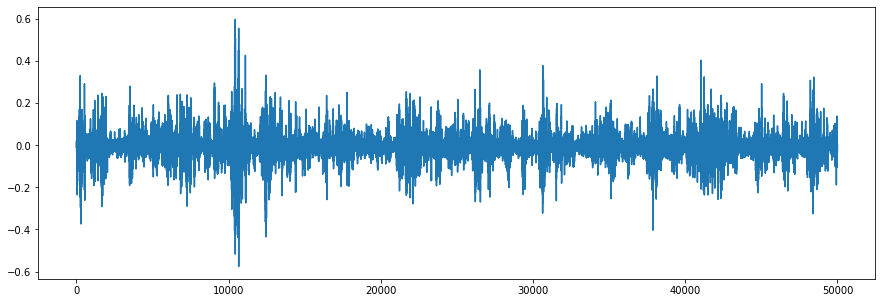

<Figure size 432x288 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (1, LATENT_DIM))
gen_sample = generator.predict(noise)
gen_sample = gen_sample.reshape(AUDIO_LENGTH, 1)

plt.figure(figsize=(15,5))
plt.plot(gen_sample[50100 : 100100])
plt.show()
plt.savefig('gen_sample' + str(len(g_loss_history)))

In [52]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

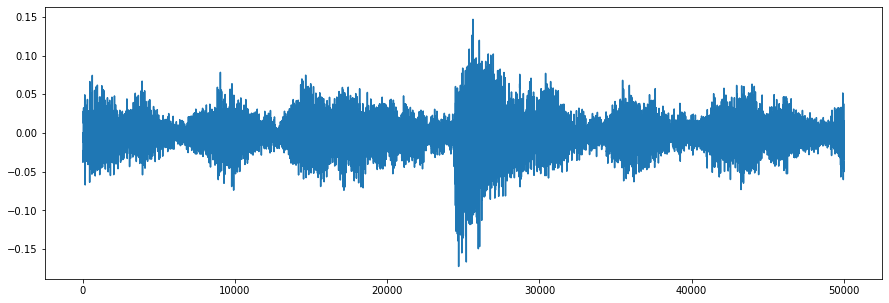

In [53]:
with open(DATASET_PATH + '/3000.pkl', 'rb') as f:
      pkl_file = pickle.load(f)
      plt.figure(figsize=(15,5))
      plt.plot(pkl_file['audio'][50100 : 100100])
      plt.show()


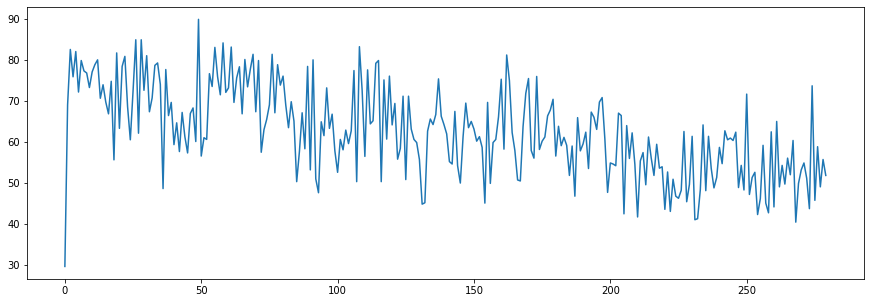

In [54]:
plt.figure(figsize=(15,5))
plt.plot(d_acc_history)

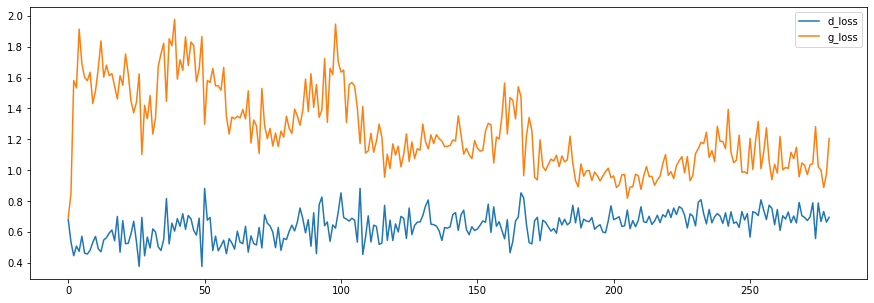

In [55]:
plt.figure(figsize=(15,5))
plt.plot(d_loss_history, label='d_loss')
plt.plot(g_loss_history, label='g_loss')
plt.legend()